# Read Kerchunked files

In [7]:
from pathlib import Path

import matplotlib.pyplot as plt

from mosaic_underice_sunlight.filepath import VIRTUAL_ZARR_JSONS
from mosaic_underice_sunlight.data.mosaic_met_kerchunker import load_metdata_zarr

In [8]:
tower = load_metdata_zarr(VIRTUAL_ZARR_JSONS['tower'])
asfs30 = load_metdata_zarr(VIRTUAL_ZARR_JSONS['asfs30'])
asfs40 = load_metdata_zarr(VIRTUAL_ZARR_JSONS['asfs40'])
asfs50 = load_metdata_zarr(VIRTUAL_ZARR_JSONS['asfs50'])

In [17]:
asfs30

<xarray.Dataset> Size: 261MB
Dimensions:                     (time: 459360)
Coordinates:
  * time                        (time) datetime64[ns] 4MB 2019-10-06 ... 2020...
Data variables: (12/70)
    atmos_pressure              (time) float64 4MB ...
    atmos_pressure_qc           (time) float64 4MB ...
    azimuth                     (time) float64 4MB ...
    azimuth_qc                  (time) float64 4MB ...
    base_time                   (time) datetime64[ns] 4MB ...
    brightness_temp_surface     (time) float64 4MB ...
    ...                          ...
    wspd_w_mean_qc              (time) float64 4MB ...
    wspd_w_std                  (time) float64 4MB ...
    zenith_apparent             (time) float64 4MB ...
    zenith_apparent_qc          (time) float64 4MB ...
    zenith_true                 (time) float64 4MB ...
    zenith_true_qc              (time) float64 4MB ...
Attributes: (12/19)
    contact:                   Matthew Shupe, University of Colorado, matthew...
    conventions:               cf convention variable naming as attribute whe...
    creator_email:             michael.r.gallagher@noaa.gov; christopher.j.co...
    data_provenance:           Based on data from the mosmet.asfs30.level2.4....
    date_created:              Fri Feb  3 11:06:54 2023
    file_creator:              Michael R. Gallagher; Christopher J. Cox
    ...                        ...
    references:                Cox, C. J., M. R. Gallagher, M. D. Shupe, P. O...
    source:                    Observations made during the Multidisciplinary...
    system:                    asfs30
    title:                     MOSAiC flux group data product
    version:                   4.1, 2/1/2023
    wind_sector_qc_info_flag:  Quality control flags specifically for wind se...

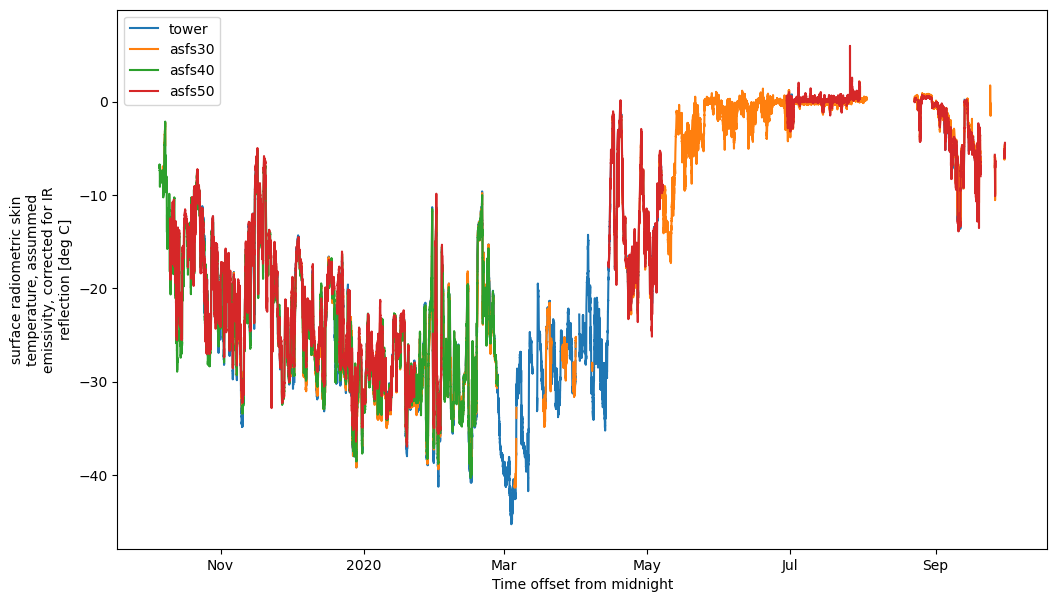

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
tower.skin_temp_surface.plot(ax=ax, label='tower')
asfs30.skin_temp_surface.plot(ax=ax, label='asfs30')
asfs40.skin_temp_surface.plot(ax=ax, label='asfs40')
asfs50.skin_temp_surface.plot(ax=ax, label='asfs50')
ax.legend()

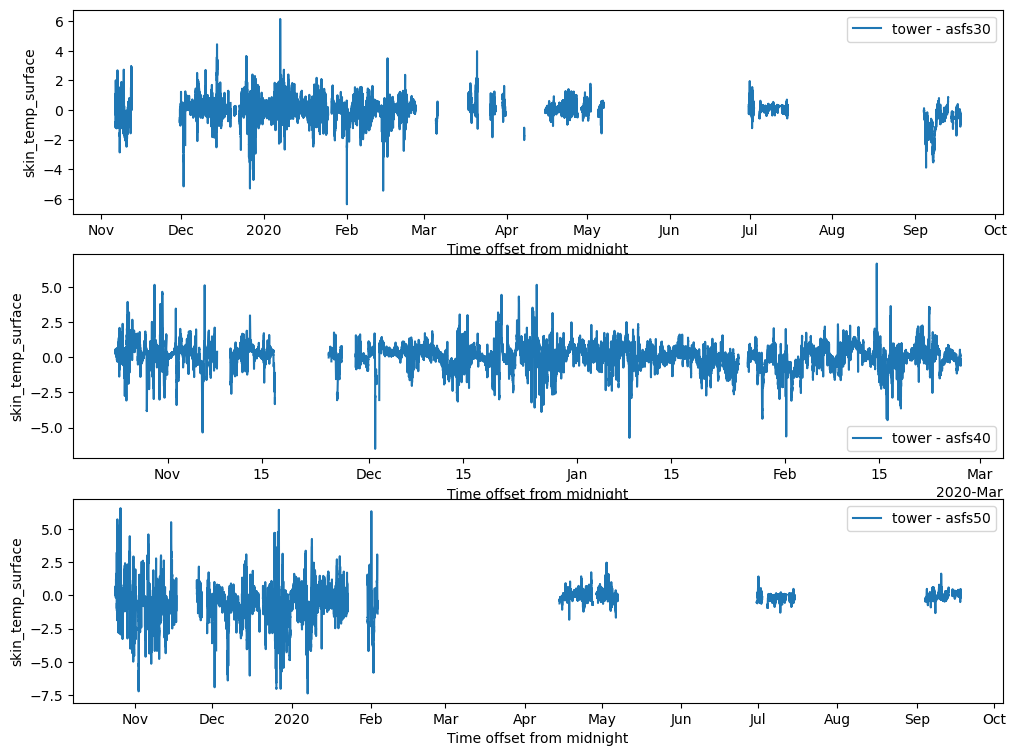

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(12,9))
(tower.skin_temp_surface - asfs30.skin_temp_surface).plot(ax=ax[0], label='tower - asfs30')
(tower.skin_temp_surface - asfs40.skin_temp_surface).plot(ax=ax[1], label='tower - asfs40')
(tower.skin_temp_surface - asfs50.skin_temp_surface).plot(ax=ax[2], label='tower - asfs50')
[axis.legend() for axis in ax]

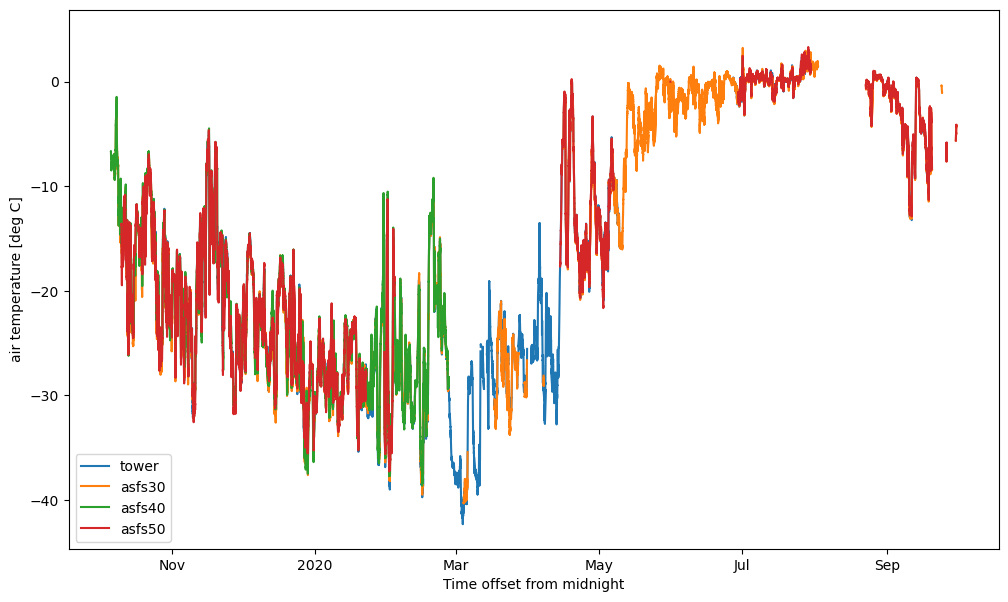

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
tower.temp_2m.plot(ax=ax, label='tower')
asfs30.temp.plot(ax=ax, label='asfs30')
asfs40.temp.plot(ax=ax, label='asfs40')
asfs50.temp.plot(ax=ax, label='asfs50')
ax.legend()

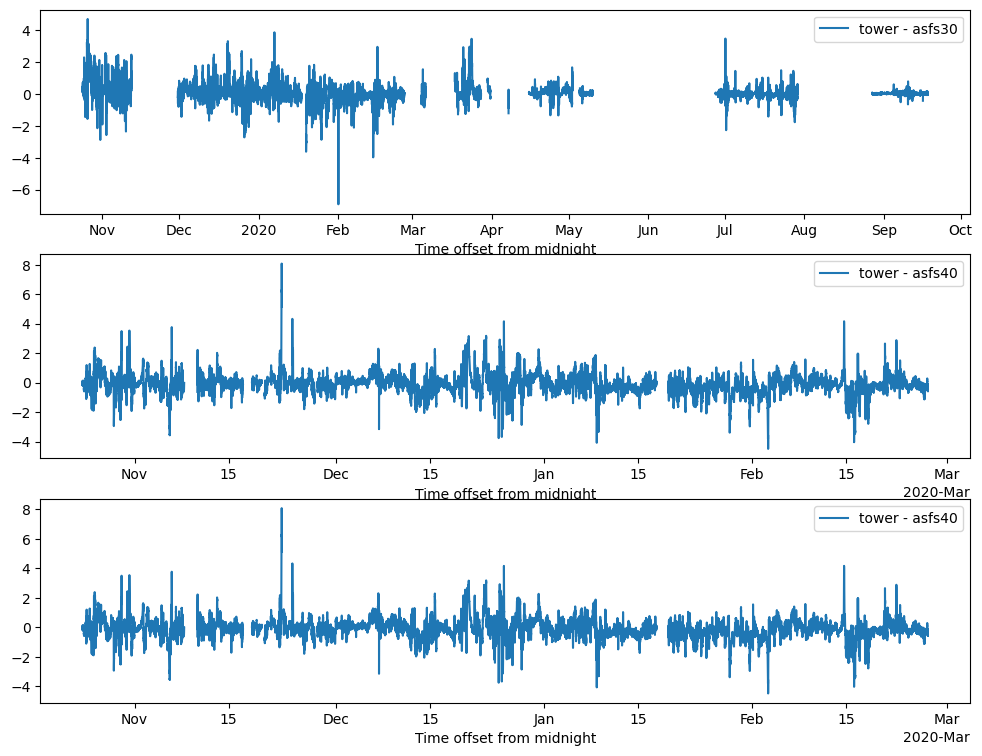

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(12,9))
for asfs, axis in zip([asfs30, asfs40, asfs40], ax):
    (tower.temp_2m - asfs.temp).plot(ax=axis, label=f'tower - {asfs.attrs["system"]}')
    axis.legend()

## Make gap-filled skin temperature series

Roughly follows David Sewells procedure

### Find gaps in tower data

In [22]:
tower.skin_temp_surface.isnull()

<xarray.DataArray 'skin_temp_surface' (time: 388800)> Size: 389kB
array([ True,  True,  True, ...,  True,  True,  True])
Coordinates:
  * time     (time) datetime64[ns] 3MB 2019-10-15 ... 2020-09-18T23:59:00

Find start and end timestamps for each site

In [33]:
for ds in [tower, asfs30, asfs40, asfs50]:
    start, end = ds.time.isel(time=[0,-1]).values
    print(f"Site: {ds.attrs["system"]:8s}  Start: {start}  End: {end}")

Site: Met City  Start: 2019-10-15T00:00:00.000000000  End: 2020-09-18T23:59:00.000000000
Site: asfs30    Start: 2019-10-06T00:00:00.000000000  End: 2020-10-01T23:59:00.000000000
Site: asfs40    Start: 2019-10-05T00:00:00.000000000  End: 2020-02-27T23:59:00.000000000
Site: asfs50    Start: 2019-10-08T00:00:00.000000000  End: 2020-10-01T23:59:00.000000000


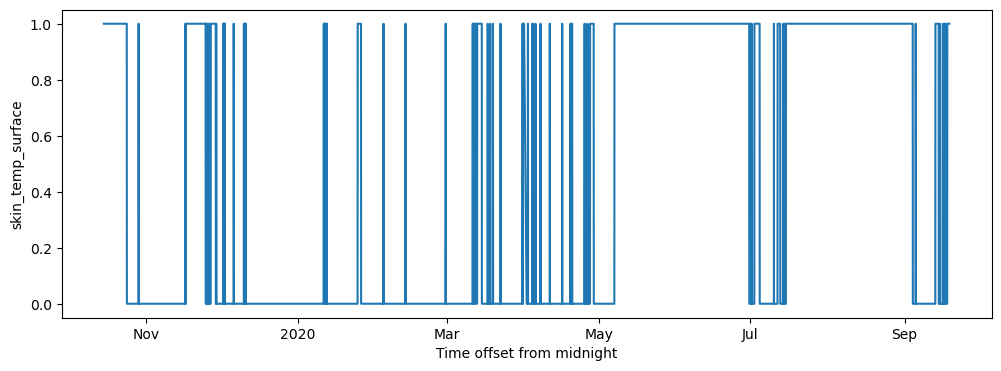

In [35]:
fig, ax = plt.subplots(figsize=(12,4))


tower.skin_temp_surface.isnull().plot(ax=ax)

In [36]:
ismissing = tower.skin_temp_surface.isnull()
missing_coded = (ismissing.diff(1) != 0).cumsum()

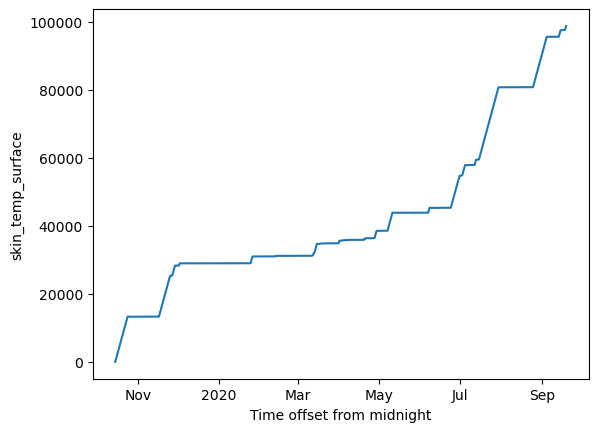

In [37]:
missing_coded.plot()

In [39]:
missing_grouped = ismissing[ismissing].groupby(missing_coded[ismissing])

In [43]:
import pandas as pd

def event_start(x):
    return x.time[0]

def event_end(x):
    return x.time[-1]

def duration(x):
    return len(x)

In [45]:
pd.DataFrame({
    "start": missing_grouped.apply(event_start),
    "end": missing_grouped.apply(event_end),
#    "duration": missing_grouped.apply(duration),
})

,start,end
0,2019-10-15 00:00:00,2019-10-15 00:00:00
1,2019-10-15 00:01:00,2019-10-15 00:01:00
2,2019-10-15 00:02:00,2019-10-15 00:02:00
3,2019-10-15 00:03:00,2019-10-15 00:03:00
4,2019-10-15 00:04:00,2019-10-15 00:04:00
...,...,...
98743,2020-09-18 23:55:00,2020-09-18 23:55:00
98744,2020-09-18 23:56:00,2020-09-18 23:56:00
98745,2020-09-18 23:57:00,2020-09-18 23:57:00
98746,2020-09-18 23:58:00,2020-09-18 23:58:00
